In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
tf.__version__

'2.13.0'

In [3]:
#!pip install imutils
import imutils

### Todo

create subset of clients

- increase comm rounds 300
- increase hidden units 400
- increase no of layers
- no of clients 20

In [4]:
debug = 0

In [5]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        #label = imgpath.split(os.path.sep)[-2]
        label = imgpath.split(os.path.sep)
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    
    return data, labels

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss


In [6]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [7]:
class SimpleCNN:
     @staticmethod    
     def build(shape, classes):
        model = Sequential()
        model.add(Input(shape=(shape[0], shape[1], shape[2])))
        model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
        model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Activation("relu"))
        model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Activation("relu"))
        model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(32))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [8]:
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import mnist

# Declare path to the MNIST dataset folder
img_path = './input/testSample/'

# Get the list of image filenames in the directory
image_filenames = os.listdir(img_path)

# Filter out non-image files (if needed)
image_filenames = [filename for filename in image_filenames if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Construct the full image paths
image_paths = [os.path.join(img_path, filename) for filename in image_filenames]

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

# Optional: Load and preprocess images from the image paths
image_list = []
label_list = []

image_paths


['./input/testSample/img_1.jpg',
 './input/testSample/img_10.jpg',
 './input/testSample/img_100.jpg',
 './input/testSample/img_101.jpg',
 './input/testSample/img_102.jpg',
 './input/testSample/img_103.jpg',
 './input/testSample/img_104.jpg',
 './input/testSample/img_105.jpg',
 './input/testSample/img_106.jpg',
 './input/testSample/img_107.jpg',
 './input/testSample/img_108.jpg',
 './input/testSample/img_109.jpg',
 './input/testSample/img_11.jpg',
 './input/testSample/img_110.jpg',
 './input/testSample/img_111.jpg',
 './input/testSample/img_112.jpg',
 './input/testSample/img_113.jpg',
 './input/testSample/img_114.jpg',
 './input/testSample/img_115.jpg',
 './input/testSample/img_116.jpg',
 './input/testSample/img_117.jpg',
 './input/testSample/img_118.jpg',
 './input/testSample/img_119.jpg',
 './input/testSample/img_12.jpg',
 './input/testSample/img_120.jpg',
 './input/testSample/img_121.jpg',
 './input/testSample/img_122.jpg',
 './input/testSample/img_123.jpg',
 './input/testSample/img_

In [9]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [11]:

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
#label_list = lb.fit_transform(label_list)

In [ ]:
# #declear path to your mnist data folder

# img_path = './input/trainingSet/trainingSet' #'../input/cifar10-pngs-in-folders/cifar10/test'  # <-- test dataset #'../input/mnistasjpg/trainingSample/trainingSample' # <-- smaller dataset
# import os 
# #get the path list using the path object
# image_paths  =  os.listdir(img_path)
# image_paths = list(paths.list_images(img_path))

# #apply our function
# image_list, label_list = load(image_paths, verbose=10000)

In [18]:


#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

ValueError: y has 0 samples: array([], dtype=float64)

In [12]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

### IID

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(315, 35, 315, 35)

In [14]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [11]:
# client_names = ['{}_{}'.format('client', i+1) for i in range(100)]
# s = clients['client_1'][0][1]*0
# for c in client_names:
#     sum = clients[c][0][1]
#     for i in range(1,378):
#         sum = sum + clients[c][i][1]
        
#     s = s + sum/378
# s

In [15]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [16]:
lr = 0.01
comms_round = 50
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

In [17]:
#initialize global model

build_shape = 784 #(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [19]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    # print(client_names, len(client_names))
    random.shuffle(client_names)
    
#     if debug: 
#         # print('all_client_names', all_client_names)
#         print('client_names', client_names, len(client_names))
                
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

ValueError: in user code:

    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\ayoub\OneDrive\Bureau\federate\env\Lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


IID | total comm rounds 0


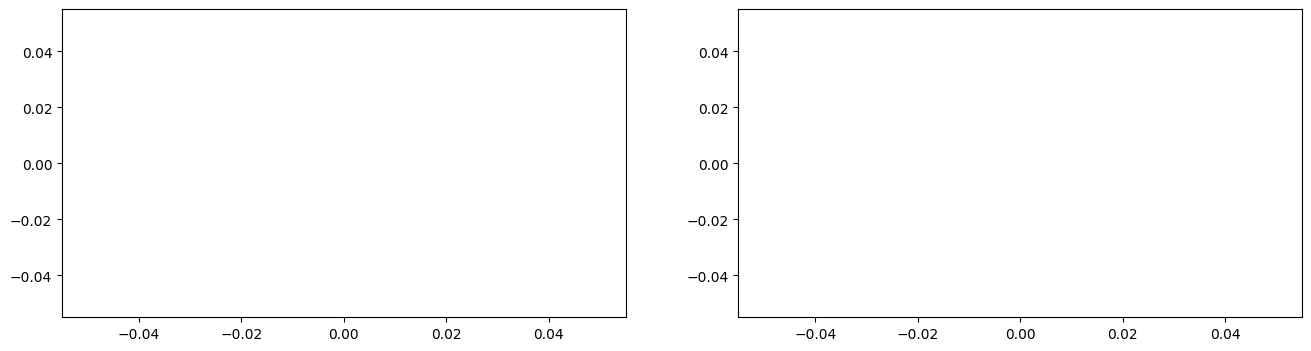

In [20]:
# IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('IID | total comm rounds', len(global_acc_list))

In [21]:
iid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
iid_df.to_csv('MNIST_IID.csv',index=False)

### MODEL AVEC CRYPTAGE HOMOMORPHE

In [22]:
type(local_model.get_weights())

list

In [23]:

!pip install PySyft
import random
import time
import logging
import numpy as np
import tenseal as ts
## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()

context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
context.generate_galois_keys()
context.global_scale = 2**40


ModuleNotFoundError: No module named 'tenseal'

In [20]:
def encrypt_parameters(param, context):
    """
    Returns encrypted parameters using Homomorphic Encryption.
    Args:
        - param (np.ndarray): parameters of a model
        - context (tenseal.Context): context for homomorphic encryption
    Returns:
        - enc_param (tenseal.CKKSTensor): encrypted parameters of the model
    """
    enc_param = ts.ckks_tensor(context, param)
    return enc_param

def decrypt_parameters(enc_param):
    """
    Decrypts encrypted parameters using Homomorphic Encryption.
    Args:
        - enc_param (tenseal.CKKSTensor): encrypted parameters of a model
    Returns:
        - param (np.ndarray): decrypted parameters of the model
    """
    param = enc_param.decrypt()
    return param


In [21]:
comms_round = 100

# Setup TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2 ** 40

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    # print(client_names, len(client_names))
    random.shuffle(client_names)
    
#     if debug: 
#         # print('all_client_names', all_client_names)
#         print('client_names', client_names, len(client_names))
                
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        local_model.get_weights()
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        
        #code original 
        
        #scale the model weights and add to list
       # scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        #scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        #scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        #K.clear_session()
      
    #to get the average over all the local model, we simply take the sum of the scaled weights
    #average_weights = sum_scaled_weights(scaled_local_weight_list)
        loc_weights=local_model.get_weights()
        print('debut cryptage')
        encrypted_loc_weight = []
        for weights in loc_weights[2]:
            print('kk')
            encrypted_weight= encrypt_parameters(weights, context)
            encrypted_loc_weight.append(encrypted_weight)
        print('fin cryptage')
        scaled_weights = scale_model_weights(encrypted_loc_weight, scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

debut cryptage
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
kk
fin cryptage
